# Neural Networks using PyTorch

In this tutorial we are going to implement a very simple neural network classifier, using our old friend, the two moons dataset.

We are going to use the PyTorch library for that. PyTorch is a modern deep learning library. On a low level, it combines numpy-like tools for linear algebra and multi-dimensional array manipulation with automatic differentiation and easy integration of GPU-Accelerators. 

On a higher level it also implements a lot of functionalities commonly needed for neural networks, e.g, the optimizers and data loading functionalities we will quickly look at now, but also many more.

The full api documentation can be found here https://pytorch.org/docs/stable/index.html , Installation instructions here https://pytorch.org/ , and in general the internet is full of PyTorch tutorials (essentially, most of the parts that are not pictures of cats), which introduce further features in more detail.

Ok, lets get started. First, we load the data:

## Load Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

train_data = dict(np.load("two_moons.npz", allow_pickle=True)) 
test_data = dict(np.load("two_moons_test.npz", allow_pickle=True))
# we need to reshape our labels so that they are [N, 1] and not [N] anymore
train_samples, train_labels = train_data["samples"], train_data["labels"][:, None]
test_samples, test_labels = test_data["samples"], test_data["labels"][:, None]

Next we have to convert the data from numpy arrays into torch tensors. Note, that for neural networks double precisiion floating points are usually not necessary, thus common neural network libraries use only single precission (`np.float32` in numpy) as default for efficiency reasons.   

In [2]:
import torch

# first convert to float 32 (single precision) then to torch tensors 
train_samples = torch.from_numpy(train_samples.astype(np.float32))
test_samples = torch.from_numpy(test_samples.astype(np.float32))
train_labels = torch.from_numpy(train_labels.astype(np.float32))
test_labels = torch.from_numpy(test_labels.astype(np.float32))

## Build Network

We are going to use `torch.nn` to build our network. `nn.Sequential` provides a callable that will pass a given input through a bunch of layers, given the layers we want to use. 

Here we define a network with 2 hidden layers with 64 neurons each, and ReLU activation. The output is our class probability, i.e., a scalar we pass through the sigmoid activation.

In [3]:
nn = torch.nn

def get_network() -> nn.Sequential:
    return nn.Sequential(
        # 1. hidden layer: linear mapping followed by ReLU
        nn.Linear(in_features=2, out_features=64),
        nn.ReLU(),
        # 2. hidden layer: linear mapping followed by ReLU
        nn.Linear(in_features=64, out_features=64),
        nn.ReLU(),
        # Output Layer: linear followed by Sigmoid
        nn.Linear(in_features=64, out_features=1),
        nn.Sigmoid())

## Build Optimizer 
To train our model, we also need an optimizer. Here we chose Adam, which is provided by the torch.optim package. We only need to specify which parameters the optimizer should optimize, but can also give values such as the learing rate or the momentum parameters.

In [4]:
opt = torch.optim

def get_optimizer(model: nn.Sequential) -> opt.Optimizer:
    return opt.Adam(params=model.parameters(),
                    lr=1e-3)

## Build Data Handling (Batching and Shuffling)

As we have seen when we implemented stochastic gradient descent from scratch earlier, we also need some functionality handling the batching and shuffling. For this we can use another torch package: `torch.utils.data`. 

First, we specifiy a dataset consisting of a set of tensors, here the train samples and labels, with the same size along the first axis (batch axis).

Next, we give this dataset to a DataLoader which provides an iterator over batches (with a specified batch size) of the shuffled data.

**Note**: The Dataset / DataLoader functionallity can be used for much more than batching and shuffling, e.g., data preprocessing and pre fetching (from disk to main-memory and from main-memory to GPU). But we won't cover this here. 


In [5]:
data = torch.utils.data

def get_train_loader() -> data.DataLoader:

    train_set = data.TensorDataset(train_samples, train_labels)
    return data.DataLoader(train_set,
                           batch_size=10, 
                           shuffle=True)

## Train and Evaluate

That's it, we have all the ingredients together and can implement our main train loop:

In [9]:
num_iters = 100

# making sure this cell behaves deterministically 
torch.manual_seed(0)
np.random.seed(0)
model = get_network()
train_loader = get_train_loader()
optimizer = get_optimizer(model=model)



train_losses = []
test_losses = []

# For several iterations .... 
for i in range(num_iters):
    # ... iterate over the batches 
    for samples, labels in train_loader:
        
        # compute model prediciton
        predictions = model(samples)
        
        # compute loss, see how we again used off-the-shelf pytroch functionality here 
        loss = nn.functional.binary_cross_entropy(input=predictions, 
                                                  target=labels,
                                                  reduction="mean")
        
        # torch stores the gradients for each parameter using buffers in the parameter object itself, 
        # we first need to clear those buffers before we can compute new gradients, we do that by calling 
        optimizer.zero_grad()
        
        # now we run the backward pass from loss, this computes all gradients and fills the gradient-"bufferes"
        # again
        loss.backward()
        
        # to apply the gradients we call
        optimizer.step()
        
        # thats it, now some book keeping and then repeat with the next batch
        train_losses.append(loss.detach().numpy())        
    
    # Once every iteration we evaluate on the whole test set. For this we use the inference_mode.
    # It tells torch that we do not need gradients for anything inside the context. Thus no intermediate
    # quantities need to be stored which makes the evaluation pass much faster and more memory efficient 
    with torch.inference_mode():
        test_predictions = model(test_samples)
        test_loss = nn.functional.binary_cross_entropy(input=test_predictions,
                                                       target=test_labels,
                                                       reduction="mean")
        test_losses.append(test_loss.numpy())

Ok, lets plot our loss and descicion boundaries 

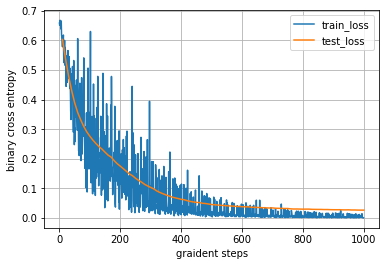

In [10]:
plt.plot(train_losses, label="train_loss")
num_train_batches = len(train_loader)
plt.plot(np.arange(num_train_batches, num_iters * num_train_batches+1, num_train_batches), 
         test_losses, label="test_loss")
plt.grid("on")
plt.xlabel("graident steps")
plt.ylabel("binary cross entropy")
plt.legend()

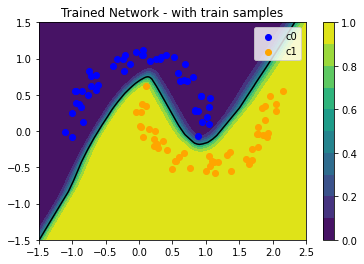

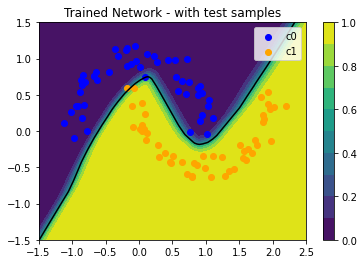

In [11]:
def plt_solution(samples, labels):
    with torch.inference_mode():
        plt_range = np.arange(-1.5, 2.5, 0.01, dtype=np.float32)
        plt_grid = np.stack(np.meshgrid(plt_range, plt_range), axis=-1)
        plt_grid_shape = plt_grid.shape[:2]
        
        flat_grid = np.reshape(plt_grid, (-1, plt_grid.shape[-1]))
        predictions = model(torch.from_numpy(flat_grid)).numpy()
        pred_grid = np.reshape(predictions, plt_grid_shape)
        plt.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=[0.5], colors=["black"])
        plt.contourf(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=10)
        plt.colorbar()
        s0 = plt.scatter(x=samples[labels[:, 0] == 0, 0], y=samples[labels[:, 0] == 0, 1],
                         label="c=0", c="blue")
        s1 = plt.scatter(x=samples[labels[:, 0] == 1, 0], y=samples[labels[:, 0] == 1, 1],
                         label="c=1", c="orange")
        plt.legend([s0, s1], ["c0", "c1"])
        plt.xlim(-1.5, 2.5)
        plt.ylim(-1.5, 1.5)


plt.figure()
plt.title("Trained Network - with train samples")
plt_solution(train_samples, train_labels)

plt.figure()
plt.title("Trained Network - with test samples")
plt_solution(test_samples, test_labels)
plt.show()